In [48]:
%matplotlib inline

In [66]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from glob import glob
from graph_tool import GraphView
from itertools import chain, combinations
from graph_helpers import load_graph_by_name
from graph_tool.draw import sfdp_layout, graph_draw

In [2]:
g = load_graph_by_name('fb')

load graph from data/fb/graph.gt


In [5]:
pos = sfdp_layout(g)

In [23]:
circles_by_uid = {}
for p in glob('data/fb/facebook/*.circles'):
    uid = int(os.path.basename(p).split('.')[0])
    circles_by_uid[uid] = []
    for l in open(p, 'r'):
        ids = list(map(int, l.split()[1:]))
        circles_by_uid[uid].append(ids)

In [70]:
gv = GraphView(g)
vfilt = gv.new_vertex_property('bool')
vfilt.set_value(False)
vfilt.a[circ] = True
gv.set_vertex_filter(vfilt)

In [89]:
circles = list(chain(*circles_by_uid.values()))
circles = [c for c in circles if len(c) >= 40]  # only large circles

In [95]:
obs_fracs = [0.1, 0.2, 0.3, 0.4, 0.5]
n_reps = 4  # num observation rounds for each circle
for obs_frac in obs_fracs:
    d = 'cascade-weighted/fb-mcircle-s-o{}'.format(obs_frac)
    if not os.path.exists(d):
        os.makedirs(d)
        
    for i, circ in enumerate(circles):
        for j in range(n_reps):
            n = len(circ)
            cas_size = int(n * obs_frac)
            obs = np.random.choice(circ, replace=False, size=cas_size)
            cascade = (np.ones(g.num_vertices()) * -1)
            cascade[circ] = 0
            
            num = i * n_reps + j
            path = '{}/{}.pkl'.format(d, num)
            pkl.dump((obs, cascade), 
                     open(path, 'wb'))

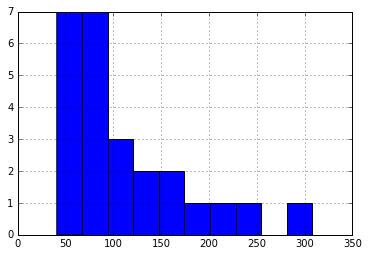

In [97]:
pd.Series(list(map(len, circles))).hist()

In [29]:
comm_by_uid = {}
for k, circles in circles_by_uid.items():
    comm_by_uid[k] = list(chain(*circles))

In [36]:
comms = g.new_vertex_property('int')
for i, nodes in enumerate(comm_by_uid.values()):
    for n in nodes:
        comms[n] = i

In [37]:
if False:
    for u1, u2 in combinations(comm_by_uid, 2):
        s1, s2 = map(set, [comm_by_uid[u1], comm_by_uid[u2]])
        if s1.intersection(s2):
            print(u1, u2, s1.intersection(s2))


In [73]:
gv_pos = sfdp_layout(gv)

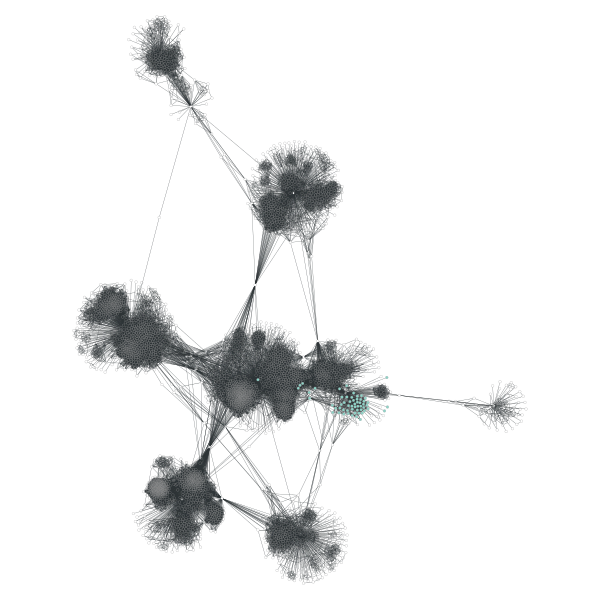

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa6042702e8, at 0x7fa605032550>

In [86]:
graph_draw(g, pos=pos, 
           vertex_fill_color=vfilt)